<a href="https://colab.research.google.com/github/Lfirenzeg/msds620/blob/main/RuneScapeSentiment/620_Final_Project_RuneScape_Network_and_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 620
## Final Project
## Network and Sentiment Analysis: A RuneScape Reddit Rendition

### By Luis Munoz Grass

#### Instructions

The project should incorporate one or both of the two main themes of this course: network analysis and text processing. We need to show all of the work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If we are building a model or models, explain how you evaluate the "goodness" of the chosen model and parameters.

## Introduction

Over the past decade, the beloved MMORPG RuneScape has experienced significant changes, both in mechanics and community sentiment. Its not unusual for gamers to debate extensively about updates, nostalgia, and comparing the two current running versions of the game: RuneScape 3 and OldSchoolRuneScape. By combining sentiment and topic analysis with reply networks, we can reveal how community perception has shifted and which topics (or players) are more prominent in those conversations.

## Method

In [2]:
!pip install praw
!pip install psaw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 1.3 MB/s eta 0:00:00


In [4]:
import os, logging
from datetime import datetime, timedelta
import pandas as pd
import re
import numpy as np
import time
import praw
import random
from psaw import PushshiftAPI
from prawcore.exceptions import TooManyRequests
import nltk

os.environ["REDDIT_CLIENT_ID"]     = "Ygc3evD_vOcy7SGCYiAjNA"
os.environ["REDDIT_CLIENT_SECRET"] =
os.environ["REDDIT_USER_AGENT"]    = "SentimentProject by u/PublicTop1182"


In [5]:
logging.getLogger("praw").setLevel(logging.ERROR)

### Instatiating PRAW

In [11]:


reddit = praw.Reddit(
    client_id    = os.environ["REDDIT_CLIENT_ID"],
    client_secret= os.environ["REDDIT_CLIENT_SECRET"],
    user_agent   = os.environ["REDDIT_USER_AGENT"]
)



Quick sanity check

In [13]:
subreddit = reddit.subreddit("runescape")
print(next(subreddit.hot(limit=5)).title)


July Quest Qol and Game Health Update - This Week In RuneScape


Fetching one submission by URL to examine if code is getting the content we need. In this case we are looking for the title, body and comments.

In [6]:
# fetching by URL
submission = reddit.submission(
    url="https://www.reddit.com/r/runescape/comments/1lk7xo0/the_future_of_mtx_our_approach_your_involvement/"
)

In [7]:
# inspect title + body
print("Title:  ", submission.title)
print("Body:   ", submission.selftext[:200], "…\n")

Title:   The Future of MTX - Our Approach & Your Involvement
Body:    Our approach to MTX is harming RuneScape. The process of change starts now.

Experiments like Disabling Treasure Hunter, preventing use of some MTX-based skilling items in our Autumn DXP & more await  …



In [9]:
# pulling every comment, nested or not
submission.comments.replace_more(limit=None)
for c in submission.comments.list():
    snippet = c.body[:100].replace("\n"," ")
    print(f"- {c.author or '[deleted]'}: {snippet}…")

- Cloud_N0ne: >Our approach to MTX is harming RuneScape  This level of candor in regard to monetization is extreme…
- Lord-Ice: I know this isn't the most positive comment, but I do still feel it needs to be said, because it's a…
- DosSantos1712: **Request for the third experiment:** could the CM team please compile a list of the most sought-aft…
- SoilIntrepid4686: I usually just lurk, but this is worth saying. Seeing this has given me another shot to hope for thi…
- aetherweaving: Brilliant and completely unexpected from Jagex to come out with this.  It's no secret to anyone (bot…
- Obvious_Ocelot_3638: MTX is hurting Rs3: We see in OSRS that the game is successful with no MTX!  Mod Hooli!  Is there go…
- rexspook: Wow I don’t think I expected a Jagex employee to actually say that first sentence out loud in an off…
- KobraTheKing: Holy shit they're going to test out disabling Treasure Hunter.  Holy shit they're going to test out …
- Objective_Toe_49: Holy Shit.  >Our approach to MTX 

## Scraping Reddit threads for Runescape 3

The following list of URLs was selected based on the relation to major updates to RuneScape 3 (RS3) over the past 13 years, selecting at least 2 threads discussing the impact of each update.

It's important to note that what constitutes an "important" update can be subjective and vary depending on individual player preferences and gameplay styles. Some players might prioritize new skills or bossing content, while others might value quality of life improvements or lore expansions.

The criteria for selecting each thread in this project was sorting the search of forums by most comments, as we are looking for the most amount of engagement possible. Each thread anywhere from 100 to over 4000 comments.

In [14]:
# URL list with update labels
threads = [
    {"url": "https://www.reddit.com/r/runescape/comments/1lk7xo0/the_future_of_mtx_our_approach_your_involvement/",
     "update": "MTX pause"},
    {"url": "https://www.reddit.com/r/runescape/comments/1loxe8u/mtx_experiment_1_disabling_th_july_22_28/",
     "update": "MTX pause"},
    {"url": "https://www.reddit.com/r/runescape/comments/zl2ctv/new_skill_confirmed_on_stream_its_necromancy/",
     "update": "Necromancy"},
    {"url": "https://www.reddit.com/r/runescape/comments/163pxlr/unpopular_opinion_necromancy_isnt_that/",
     "update": "Necromancy"},
    {"url": "https://www.reddit.com/r/runescape/comments/1jdkjny/jagex_accidentally_created_a_whole_new_game_genre/",
     "update": "New Foundations & DXP"},
    {"url": "https://www.reddit.com/r/runescape/comments/152ekmg/petition_to_add_more_banks_to_fort_forinthry/",
     "update": "New Foundations & DXP"},
    {"url": "https://www.reddit.com/r/runescape/comments/fw54sy/mega_thead_archaeology_one_week_in_archaeology/",
     "update": "Archaeology"},
    {"url": "https://www.reddit.com/r/runescape/comments/f9dhf5/archaeology_launch_date_unearthed_march_30th/",
     "update": "Archaeology"},
    {"url": "https://www.reddit.com/r/runescape/comments/adq2m5/to_jagex_you_aced_the_mining_and_smithing_rework/",
     "update": "Mining & Smithing Rework"},
    {"url": "https://www.reddit.com/r/runescape/comments/9wo5by/mining_smithing_beta_official_feedback_thread/",
     "update": "Mining & Smithing Rework"},
    {"url": "https://www.reddit.com/r/runescape/comments/9cla0q/player_owned_farm/",
     "update": "Player Owned Farm"},
    {"url": "https://www.reddit.com/r/runescape/comments/a1adw9/player_owned_farm/",
     "update": "Player Owned Farm"},
    {"url": "https://www.reddit.com/r/runescape/comments/12x4l4/evolution_of_combat_survey_results/",
     "update": "Evolution of Combat"},
    {"url": "https://www.reddit.com/r/runescape/comments/10dy85/its_almost_time_for_the_fourth_and_final_live_qa/",
     "update": "Evolution of Combat"}
]

In [15]:
#  Pull all submissions and comments
posts   = []
comments= []

for t in threads:
    sub = reddit.submission(url=t["url"])
    # submission info
    posts.append({
        "update":      t["update"],
        "url":         t["url"],
        "id":          sub.id,
        "title":       sub.title,
        "body":        sub.selftext,
        "author":      str(sub.author),
        "created_utc": datetime.fromtimestamp(sub.created_utc),
        "score":       sub.score,
        "upvote_ratio":sub.upvote_ratio
    })
    # comments
    sub.comments.replace_more(limit=None)
    for c in sub.comments.list():
        comments.append({
            "update":       t["update"],
            "url":          t["url"],
            "submission_id":sub.id,
            "comment_id":   c.id,
            "author":       str(c.author),
            "body":         c.body,
            "created_utc":  datetime.fromtimestamp(c.created_utc),
            "score":        c.score
        })


In [16]:
# converting to data frames for downstream analysis
df_posts    = pd.DataFrame(posts)
df_comments = pd.DataFrame(comments)


In [17]:
# Quick peek
print(df_posts.head())
print(df_comments.head())

                  update                                                url  \
0              MTX pause  https://www.reddit.com/r/runescape/comments/1l...   
1              MTX pause  https://www.reddit.com/r/runescape/comments/1l...   
2             Necromancy  https://www.reddit.com/r/runescape/comments/zl...   
3             Necromancy  https://www.reddit.com/r/runescape/comments/16...   
4  New Foundations & DXP  https://www.reddit.com/r/runescape/comments/1j...   

        id                                              title  \
0  1lk7xo0  The Future of MTX - Our Approach & Your Involv...   
1  1loxe8u      MTX Experiment 1: Disabling TH (July 22 - 28)   
2   zl2ctv    NEW SKILL CONFIRMED ON STREAM! IT'S NECROMANCY!   
3  163pxlr  Unpopular Opinion - Necromancy isn’t that over...   
4  1jdkjny  Jagex "accidentally" created a whole new game ...   

                                                body                author  \
0  Our approach to MTX is harming RuneScape. The ...    

In case we need to manipulate the data offline we can also save it as CSV for easy export. In this case it needs to be transformed to the desired format, and then uploaded to Google Drive.

In [18]:
df_posts.to_csv('runescape_rs3_threads.csv', index=False)
df_comments.to_csv('runescape_rs3_comments.csv', index=False)

print("Saved df_posts to 'runescape_rs3_threads.csv'")
print("Saved df_comments to 'runescape_rs3_comments.csv'")

Saved df_posts to 'runescape_rs3_threads.csv'
Saved df_comments to 'runescape_rs3_comments.csv'


In [19]:
from google.colab import drive
drive.mount('/content/drive')

# then
!cp runescape_rs3_threads.csv /content/drive/MyDrive/
!cp runescape_rs3_comments.csv /content/drive/MyDrive/

Mounted at /content/drive


## Scraping Reddit threads for OldSchoolRunescape

Now that we have the data for modern RuneScape we can continue with the same method to get the text we need to compare both RuneScape versions, so we'll focus on pulling threads from OldSchoolRunescape also known as OSRS. The list of URLs was also selected based on the connection they had to major updates  over the past 13 years, selecting at least 2 threads discussing the impact of each update. The criteria for selecting each thread was sorting the search of forums by most comments, as we are looking for the most amount of engagement possible. Each thread anywhere from 100 to over 4000 comments.

In [20]:
# defining ORSR list of URLs with update labels
osrs_threads = [
    {"url": "https://www.reddit.com/r/2007scape/comments/10x3kuy/forestry_the_way_of_the_forester_overview/",
     "update": "Forestry"},
    {"url": "https://www.reddit.com/r/2007scape/comments/11m5h8j/forestry_poll_results/",
     "update": "Forestry"},
    {"url": "https://www.reddit.com/r/2007scape/comments/15a7kjm/cant_wait_for_desert_treasure_2_to_come_out_in_a/",
     "update": "Desert Treasure II"},
    {"url": "https://www.reddit.com/r/2007scape/comments/zi3g7h/desert_treasure_ii_the_fallen_empire_coming/",
     "update": "Desert Treasure II"},
    {"url": "https://www.reddit.com/r/2007scape/comments/x45nkl/tombs_of_amascut_balance_changes_revisited/",
     "update": "Tombs of Amascut"},
    {"url": "https://www.reddit.com/r/2007scape/comments/rmvdvr/tombs_of_amascut_and_more_quests/",
     "update": "Tombs of Amascut"},
    {"url": "https://www.reddit.com/r/2007scape/comments/pt4n9x/group_ironman_has_passed_the_poll/",
     "update": "Group Ironman"},
    {"url": "https://www.reddit.com/r/2007scape/comments/pfr3no/group_ironman_blog/",
     "update": "Group Ironman"},
    {"url": "https://www.reddit.com/r/2007scape/comments/aei10v/the_kebos_lowlands/",
     "update": "The Kebos Lowlands"},
    {"url": "https://www.reddit.com/r/2007scape/comments/agbe62/poll_blog_post_release_changes_to_kebos/",
     "update": "The Kebos Lowlands"},
    {"url": "https://www.reddit.com/r/2007scape/comments/1jpkpio/poll_83_castle_wars_update/",
     "update": "F2P Castle Wars"},
    {"url": "https://www.reddit.com/r/2007scape/comments/bo80mk/jagex_mentioned_they_are_looking_for_more/",
     "update": "F2P Castle Wars"}
]

In [24]:
# Split into 3 roughly equal chunks
chunk_size = 4
chunks = [osrs_threads[i:i + chunk_size] for i in range(0, len(osrs_threads), chunk_size)]

all_posts = []
all_comments = []

for idx, chunk in enumerate(chunks, start=1):
    temp_posts = []
    temp_comments = []
    print(f"=== Processing chunk {idx}/{len(chunks)} ===")

    for thread in chunk:
        sub = reddit.submission(url=thread["url"])
        # Collect submission info
        temp_posts.append({
            "update":       thread["update"],
            "url":          thread["url"],
            "id":           sub.id,
            "title":        sub.title,
            "body":         sub.selftext,
            "author":       str(sub.author),
            "created_utc":  datetime.fromtimestamp(sub.created_utc),
            "score":        sub.score,
            "upvote_ratio": sub.upvote_ratio
        })

        # Fetch comments with retry on rate‑limit
        try:
            sub.comments.replace_more(limit=None)
        except TooManyRequests:
            print("  ✋ Rate limit hit — sleeping 60s then retrying replace_more()")
            time.sleep(60)
            sub.comments.replace_more(limit=None)

        for c in sub.comments.list():
            temp_comments.append({
                "update":        thread["update"],
                "url":           thread["url"],
                "submission_id": sub.id,
                "comment_id":    c.id,
                "author":        str(c.author),
                "body":          c.body,
                "created_utc":   datetime.fromtimestamp(c.created_utc),
                "score":         c.score
            })

        # brief pause between submissions
        time.sleep(5)

    # Save each chunk to CSV
    df_p = pd.DataFrame(temp_posts)
    df_c = pd.DataFrame(temp_comments)
    df_p.to_csv(f'osrs_posts_chunk{idx}.csv', index=False)
    df_c.to_csv(f'osrs_comments_chunk{idx}.csv', index=False)
    print(f"Chunk {idx} saved: osrs_posts_chunk{idx}.csv, osrs_comments_chunk{idx}.csv")

    # Accumulate into master lists
    all_posts.extend(temp_posts)
    all_comments.extend(temp_comments)

    # Wait before next chunk to respect rate limits
    print("Sleeping 120 seconds before next chunk...")
    time.sleep(120)

=== Processing chunk 1/3 ===
Chunk 1 saved: osrs_posts_chunk1.csv, osrs_comments_chunk1.csv
Sleeping 120 seconds before next chunk...
=== Processing chunk 2/3 ===
Chunk 2 saved: osrs_posts_chunk2.csv, osrs_comments_chunk2.csv
Sleeping 120 seconds before next chunk...
=== Processing chunk 3/3 ===
Chunk 3 saved: osrs_posts_chunk3.csv, osrs_comments_chunk3.csv
Sleeping 120 seconds before next chunk...


In [26]:
# converting to data frames
df_osrs_posts    = pd.DataFrame(all_posts)
df_osrs_comments = pd.DataFrame(all_comments)



In [28]:
# previewing the first few rows
print(f"Total OSRS posts: {len(df_osrs_posts)}")
print(f"Total OSRS comments: {len(df_osrs_comments)}")

Total OSRS posts: 12
Total OSRS comments: 9994


In [29]:
# saving to CSV
df_osrs_posts.to_csv('osrs_thread_posts.csv', index=False)
df_osrs_comments.to_csv('osrs_thread_comments.csv', index=False)
print("Saved OSRS posts/comments to CSV.")

Saved OSRS posts/comments to CSV.


In [32]:
# then
!cp osrs_thread_posts.csv /content/drive/MyDrive/
!cp osrs_thread_comments.csv /content/drive/MyDrive/

## Loading Data from GitHub

The previous section demonstrated how the data was extracted from reddit via API. However, for improved reproducibility of this notebook, the CSVs that were saved previously and uploaded to GitHub will work as the "starting point" if the notebook needs to be restarted or ran by someone else without having to download the files in the same session. This also allows for removing the secret key to the API.

In [6]:
# URLs to raw CSVs on GitHub
RS3_POSTS_URL    = "https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/RunesScapeSentiment/runescape_rs3_threads.csv"
RS3_COMMS_URL    = "https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/RunesScapeSentiment/runescape_rs3_comments.csv"
OSRS_POSTS_URL   = "https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/RunesScapeSentiment/osrs_thread_posts.csv"
OSRS_COMMS_URL   = "https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/RunesScapeSentiment/osrs_thread_comments.csv"


In [7]:
# reading them in, parsing dates
df_rs3_posts = pd.read_csv(RS3_POSTS_URL,
                       parse_dates=["created_utc"])
df_rs3_comments = pd.read_csv(RS3_COMMS_URL,
                          parse_dates=["created_utc"])
df_osrs_posts = pd.read_csv(OSRS_POSTS_URL,
                            parse_dates=["created_utc"])
df_osrs_comments = pd.read_csv(OSRS_COMMS_URL,
                               parse_dates=["created_utc"])

## Building the Networks

To build the user network, we can start with the user-thread bipartite graph. We'll define "user" and "thread" nodes and add edges for each comment. From there, we'll project it onto a user-user network by weighting the edges. We'll also want to compute centralities like degree, betweenness, and eigenvector to assess user importance.

### RS3 Network

In [8]:
!pip install networkx matplotlib --quiet

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# Building the bipartite user–thread network for RS3

B_rs3 = nx.Graph()
# Add thread nodes (prefix with T_)
for tid in df_rs3_posts['id'].unique():
    B_rs3.add_node(f"T_{tid}", bipartite='thread')

In [11]:
# adding user nodes and edges: thanks to reddit structure we just add prefix users with U_
for _, comment in df_rs3_comments.iterrows():
    user = f"U_{comment['author']}"
    thread = f"T_{comment['submission_id']}"
    B_rs3.add_node(user, bipartite='user')
    B_rs3.add_edge(user, thread)

In [12]:
# Project to user–user weighted graph
users_rs3 = [n for n, d in B_rs3.nodes(data=True) if d['bipartite']=='user']
G_rs3 = nx.bipartite.weighted_projected_graph(B_rs3, users_rs3)

In [13]:
# Compute centralities
deg_rs3     = nx.degree_centrality(G_rs3)
betw_rs3    = nx.betweenness_centrality(G_rs3)
clos_rs3    = nx.closeness_centrality(G_rs3)
eig_rs3     = nx.eigenvector_centrality(G_rs3, max_iter=1000)

In [14]:
# assemble into DataFrames
rs3_cent = pd.DataFrame({
    'user': list(deg_rs3.keys()),
    'degree'      : list(deg_rs3.values()),
    'betweenness' : [betw_rs3[u]  for u in deg_rs3],
    'closeness'   : [clos_rs3[u]  for u in deg_rs3],
    'eigenvector' : [eig_rs3[u]   for u in deg_rs3]
})

In [15]:
rs3_cent = rs3_cent[rs3_cent['user'] != 'U_nan']



### OSRS Network

In [16]:
B_osrs = nx.Graph()
for tid in df_osrs_posts['id'].unique():
    B_osrs.add_node(f"T_{tid}", bipartite='thread')

for _, comment in df_osrs_comments.iterrows():
    user = f"U_{comment['author']}"
    thread = f"T_{comment['submission_id']}"
    B_osrs.add_node(user, bipartite='user')
    B_osrs.add_edge(user, thread)

users_osrs = [n for n, d in B_osrs.nodes(data=True) if d['bipartite']=='user']
G_osrs = nx.bipartite.weighted_projected_graph(B_osrs, users_osrs)





In [17]:
deg_osrs    = nx.degree_centrality(G_osrs)


In [18]:
betw_osrs = nx.betweenness_centrality(G_osrs, k=100, seed=488)

In [19]:
clos_osrs   = nx.closeness_centrality(G_osrs)
eig_osrs    = nx.eigenvector_centrality(G_osrs, max_iter=1000)

In [20]:
osrs_cent = pd.DataFrame({
    'user': list(deg_osrs.keys()),
    'degree'      : list(deg_osrs.values()),
    'betweenness' : [betw_osrs[u] for u in deg_osrs],
    'closeness'   : [clos_osrs[u] for u in deg_osrs],
    'eigenvector' : [eig_osrs[u]  for u in deg_osrs]
})

In [21]:
osrs_cent= osrs_cent[osrs_cent['user'] != 'U_nan']

In [22]:
# -- Display top 10 for each centrality & each game --
for game, df in [('RS3', rs3_cent), ('OSRS', osrs_cent)]:
    print(f"\n=== Top 10 {game} by Degree ===")
    print(df.nlargest(10, 'degree')[['user','degree']].to_string(index=False))
    print(f"\n=== Top 10 {game} by Betweenness ===")
    print(df.nlargest(10, 'betweenness')[['user','betweenness']].to_string(index=False))
    print(f"\n=== Top 10 {game} by Closeness ===")
    print(df.nlargest(10, 'closeness')[['user','closeness']].to_string(index=False))
    print(f"\n=== Top 10 {game} by Eigenvector ===")
    print(df.nlargest(10, 'eigenvector')[['user','eigenvector']].to_string(index=False))



=== Top 10 RS3 by Degree ===
           user   degree
   U_Legal_Evil 0.757258
U_Mage_Girl_91_ 0.648790
        U_zenyl 0.641935
    U_Prcrstntr 0.634274
       U_Teakeh 0.634274
  U_lady_ninane 0.634274
 U_MikeSouthPaw 0.618952
  U_Fadman_Loki 0.586694
        U_yuei2 0.586694
     U_igornist 0.582258

=== Top 10 RS3 by Betweenness ===
           user  betweenness
   U_Legal_Evil     0.025978
      U_ImRubic     0.015403
 U_MikeSouthPaw     0.013848
        U_zenyl     0.013764
U_Mage_Girl_91_     0.013409
     U_F-Lambda     0.011397
    U_Ik_oClock     0.009638
     U_Pulsefel     0.009586
     U_igornist     0.009459
    U_Prcrstntr     0.008950

=== Top 10 RS3 by Closeness ===
           user  closeness
   U_Legal_Evil   0.804672
U_Mage_Girl_91_   0.740078
        U_zenyl   0.736342
    U_Prcrstntr   0.732211
       U_Teakeh   0.732211
  U_lady_ninane   0.732211
 U_MikeSouthPaw   0.724088
  U_Fadman_Loki   0.707561
        U_yuei2   0.707561
     U_igornist   0.705347

=== Top 10

### Prominent users

We can start noticing a few things at once:

 - U_Legal_Evil dominates RS3 on every measure, and even shows up as the top bridge in OSRS. That tells us this person not only comments on the most threads (degree) but also connects what would otherwise be separate parts of the discussion (betweenness), sits "near" all others in the graph (closeness), and is tied to other highly central users (eigenvector).

 - Meanwhile, in OSRS, U_WastingEXP pulls ahead on degree, closeness and eigenvector, and they're even more of a “hub” there than U_Legal_Evil is on RS3.

 - On RS3, U_ImRubic pops up in betweenness (2nd place) despite a more modest degree. This implies they comment in threads that otherwise wouldn't overlap. This can make them a true "connector".

- On OSRS, U_DivineInsanityReveng and U_lukwes1 similarly bridge clusters with relatively fewer total connections.

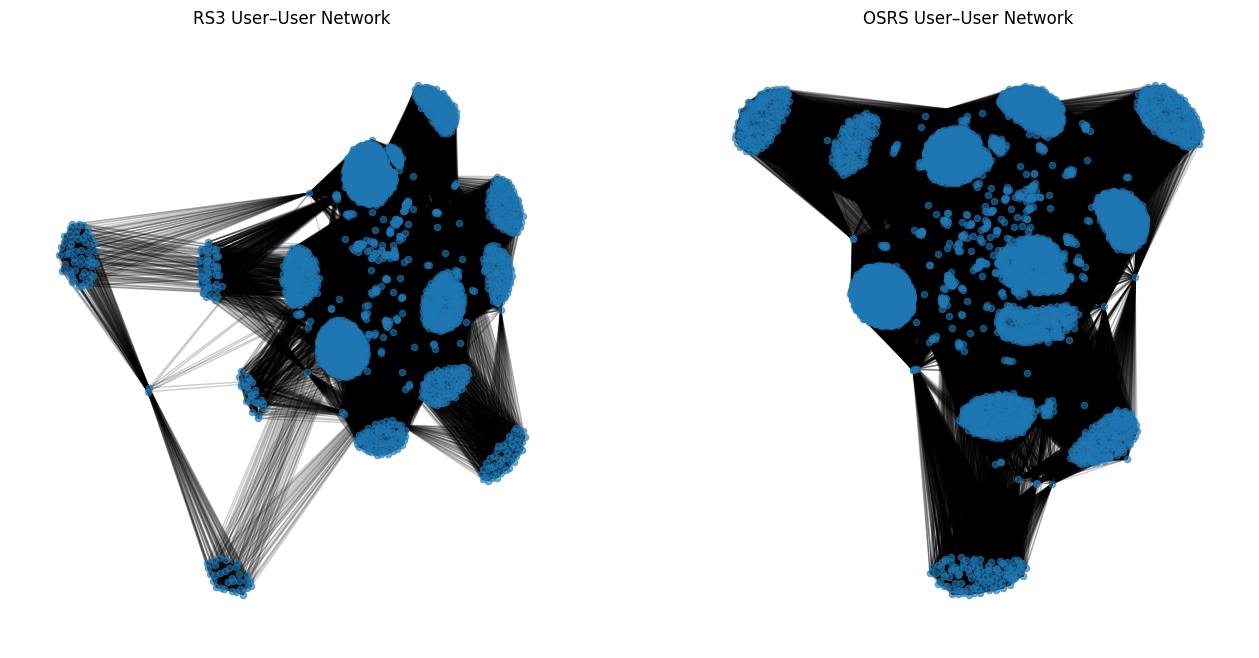

In [79]:
# visualizing user-user networks of both rs side by side
fig, axes = plt.subplots(1, 2, figsize=(16,8))
pos1 = nx.spring_layout(G_rs3, seed=42, k=0.2)
axes[0].set_title("RS3 User–User Network")
nx.draw_networkx_nodes(G_rs3, pos1, ax=axes[0], node_size=20, alpha=0.6)
nx.draw_networkx_edges(G_rs3, pos1, ax=axes[0], alpha=0.2)
axes[0].axis('off')

pos2 = nx.spring_layout(G_osrs, seed=42, k=0.2)
axes[1].set_title("OSRS User–User Network")
nx.draw_networkx_nodes(G_osrs, pos2, ax=axes[1], node_size=20, alpha=0.6)
nx.draw_networkx_edges(G_osrs, pos2, ax=axes[1], alpha=0.2)
axes[1].axis('off')

plt.show()

## Exploring communities

In [23]:
from networkx.algorithms.community import greedy_modularity_communities

In [24]:
# applying community detection via greedy modularity

# RS3 communities
comm_rs3 = list(greedy_modularity_communities(G_rs3, weight='weight'))
print(f"RS3: found {len(comm_rs3)} communities; sizes = {[len(c) for c in comm_rs3]}")

# OSRS communities
comm_osrs = list(greedy_modularity_communities(G_osrs, weight='weight'))
print(f"OSRS: found {len(comm_osrs)} communities; sizes = {[len(c) for c in comm_osrs]}")

RS3: found 7 communities; sizes = [679, 667, 390, 370, 231, 90, 54]
OSRS: found 11 communities; sizes = [696, 570, 456, 445, 403, 391, 315, 259, 191, 177, 118]


### Community structure
We get that RS3 splits into 7 major user-clusters, the two largest containing roughly 670 users each, down to a small fringe of about 50.

Meanwhile, OSRS fragments into 11 clusters, with a more even decline from around 700 down to approx 120.

We could say then that OSRS discussions divide into more and smaller groups. Perhaps from  more topic or thread specific subcommunities, while RS3 users seem to congregate into fewer but larger clusters.

In [36]:
#  density (exact)
dens_rs3  = nx.density(G_rs3)
dens_osrs = nx.density(G_osrs)

In [37]:
# transitivity (global clustering, exact)
trans_rs3  = nx.transitivity(G_rs3)

In [38]:
trans_osrs = nx.transitivity(G_osrs)

In [41]:
# approximate average clustering by sampling
def approx_avg_clustering(G, k=200):
    nodes = list(G)
    sample = random.sample(nodes, min(k, len(nodes)))
    vals   = nx.clustering(G, nodes=sample, weight='weight').values()
    return sum(vals) / len(vals)

avgclust_rs3  = approx_avg_clustering(G_rs3,  k=300)
avgclust_osrs = approx_avg_clustering(G_osrs, k=300)

In [42]:
# centralization (degree‐based)
cent_rs3 = max(deg_rs3.values()) - sum(deg_rs3.values())/len(deg_rs3)
cent_osrs= max(deg_osrs.values())- sum(deg_osrs.values())/len(deg_osrs)

In [43]:
# 5) Report
print("RS3 Metrics:")
print(f" Density:           {dens_rs3:.4f}")
print(f" Transitivity:      {trans_rs3:.4f}")
print(f" Avg. clustering ≈  {avgclust_rs3:.4f}")
print(f" Centralization:    {cent_rs3:.4f}")

print("\nOSRS Metrics:")
print(f" Density:           {dens_osrs:.4f}")
print(f" Transitivity:      {trans_osrs:.4f}")
print(f" Avg. clustering ≈  {avgclust_osrs:.4f}")
print(f" Centralization:    {cent_osrs:.4f}")

RS3 Metrics:
 Density:           0.1889
 Transitivity:      0.8852
 Avg. clustering ≈  0.1591
 Centralization:    0.8111

OSRS Metrics:
 Density:           0.1400
 Transitivity:      0.7903
 Avg. clustering ≈  0.1041
 Centralization:    0.8600


- Density is significantly higher in RS3, nearly 19% vs 14%.
- Transitivity is also higher in RS3, indicating that if user A links to B and B to C, there's an 88.5% chance A also links to C, versus 79% in OSRS.

From this we could infer that RS3'ss network is more tightly interwoven: users tend to co-comment in multiple shared threads, forming dense, triadic communities. OSRS is looser with more one to one interactions.

- Average clustering is higher in RS3, reinforcing the idea of a structure more cliquey.

- Centralization is higher in OSRS, meaning OSRS relies more heavily on a small number of super connectors.

So while RS3 has denser local groupings, OSRS's graph is more star like around key hubs. OSRS discussions may depend more on a handful of highly active users to bridge its many subcommunities. RS3 conversations feel more evenly distributed among clusters.




In [44]:
# Build mapping from node to community index
node_comm_rs3 = {node: idx for idx, community in enumerate(comm_rs3) for node in community}
node_comm_osrs = {node: idx for idx, community in enumerate(comm_osrs) for node in community}

In [45]:
# preparing colors
cmap_rs3 = plt.cm.get_cmap('tab10', len(comm_rs3))
cmap_osrs = plt.cm.get_cmap('tab20', len(comm_osrs))

colors_rs3 = [node_comm_rs3.get(node) for node in G_rs3.nodes()]
colors_osrs = [node_comm_osrs.get(node) for node in G_osrs.nodes()]

# setting layout
pos_rs3 = nx.spring_layout(G_rs3, seed=42, k=0.2)
pos_osrs = nx.spring_layout(G_osrs, seed=42, k=0.2)



/tmp/ipython-input-45-1646037794.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_rs3 = plt.cm.get_cmap('tab10', len(comm_rs3))
/tmp/ipython-input-45-1646037794.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_osrs = plt.cm.get_cmap('tab20', len(comm_osrs))


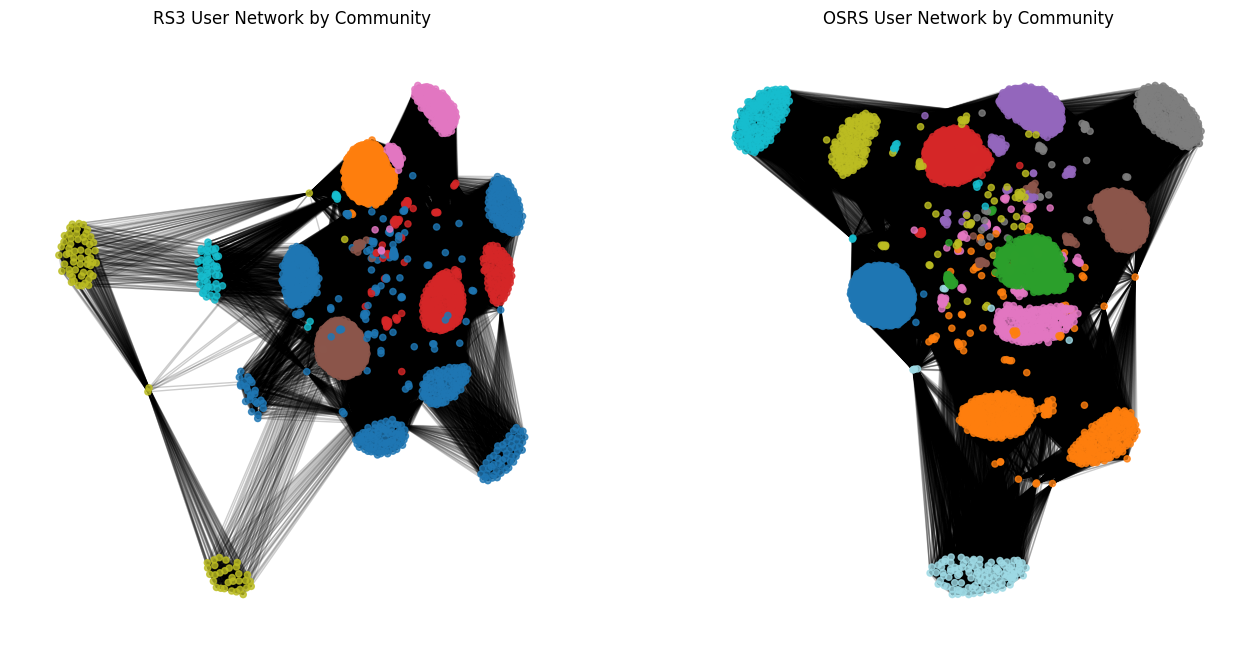

In [46]:
# plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].set_title("RS3 User Network by Community")
nx.draw_networkx_nodes(G_rs3, pos_rs3, node_color=colors_rs3, cmap=cmap_rs3,
                       node_size=20, alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G_rs3, pos_rs3, alpha=0.2, ax=axes[0])
axes[0].axis('off')

axes[1].set_title("OSRS User Network by Community")
nx.draw_networkx_nodes(G_osrs, pos_osrs, node_color=colors_osrs, cmap=cmap_osrs,
                       node_size=20, alpha=0.8, ax=axes[1])
nx.draw_networkx_edges(G_osrs, pos_osrs, alpha=0.2, ax=axes[1])
axes[1].axis('off')

plt.show()

We can see seven distinct blobs in the RS3 graph. The two largest (blue and red in our plot) each contain about 670 users. They are likely related because of the "big update" discussions (such as MTX pause vs. Necromancy), while the smaller violet/orange clusters (of around 90 to 231 users) probably map to lower-engagement updates like Player Owned Farm.

But for OSRS we see the user base splits into even more islands—each update (Forestry, Tombs of Amascut, etc.) spawns its own sizable cluster of 350 to 700 users, plus a handful of very small, niche groups.

We can see again OSRS conversations more topic segmented. We get a one to one roughly between update and community, while RS3 users overlap more, so only 7 groups span 6 updates.

## Sentiment Analysis

In [28]:
!pip install vaderSentiment --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 594.0 kB/s eta 0:00:00


In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [49]:
# initialize the analyzer
sia = SentimentIntensityAnalyzer()

In [50]:
# compute the compound sentiment for each df
for df, name in [
    (df_rs3_posts,    'rs3_posts'),
    (df_rs3_comments, 'rs3_comments'),
    (df_osrs_posts,   'osrs_posts'),
    (df_osrs_comments,'osrs_comments')
]:
    df['sentiment'] = df['body'].fillna('').apply(lambda txt: sia.polarity_scores(txt)['compound'])


In [51]:
# we want to tag each game in each df
df_rs3_posts['game']     = 'RS3'
df_rs3_comments['game']  = 'RS3'
df_osrs_posts['game']    = 'OSRS'
df_osrs_comments['game'] = 'OSRS'

In [52]:
# finally we can summarize average sentiment by game and update
posts_summary = pd.concat([df_rs3_posts, df_osrs_posts]) \
    .groupby(['game','update'])['sentiment'] \
    .mean().reset_index().rename(columns={'sentiment':'avg_post_sentiment'})

comments_summary = pd.concat([df_rs3_comments, df_osrs_comments]) \
    .groupby(['game','update'])['sentiment'] \
    .mean().reset_index().rename(columns={'sentiment':'avg_comment_sentiment'})

sentiment_summary = posts_summary.merge(comments_summary, on=['game','update'])


In [53]:
# Display the summary table
print("Average Sentiment by Game & Update:\n")
print(sentiment_summary.to_string(index=False))


Average Sentiment by Game & Update:

game                   update  avg_post_sentiment  avg_comment_sentiment
OSRS       Desert Treasure II             0.00000               0.114080
OSRS          F2P Castle Wars            -0.42550               0.067686
OSRS                 Forestry             0.00000               0.204673
OSRS            Group Ironman             0.00000               0.120342
OSRS       The Kebos Lowlands             0.00000               0.104601
OSRS         Tombs of Amascut             0.00000               0.225465
 RS3              Archaeology             0.49420               0.183030
 RS3      Evolution of Combat             0.16835               0.147622
 RS3                MTX pause             0.87860               0.414399
 RS3 Mining & Smithing Rework            -0.10860               0.170109
 RS3               Necromancy             0.48265               0.059432
 RS3    New Foundations & DXP             0.43955               0.138883
 RS3        Pl

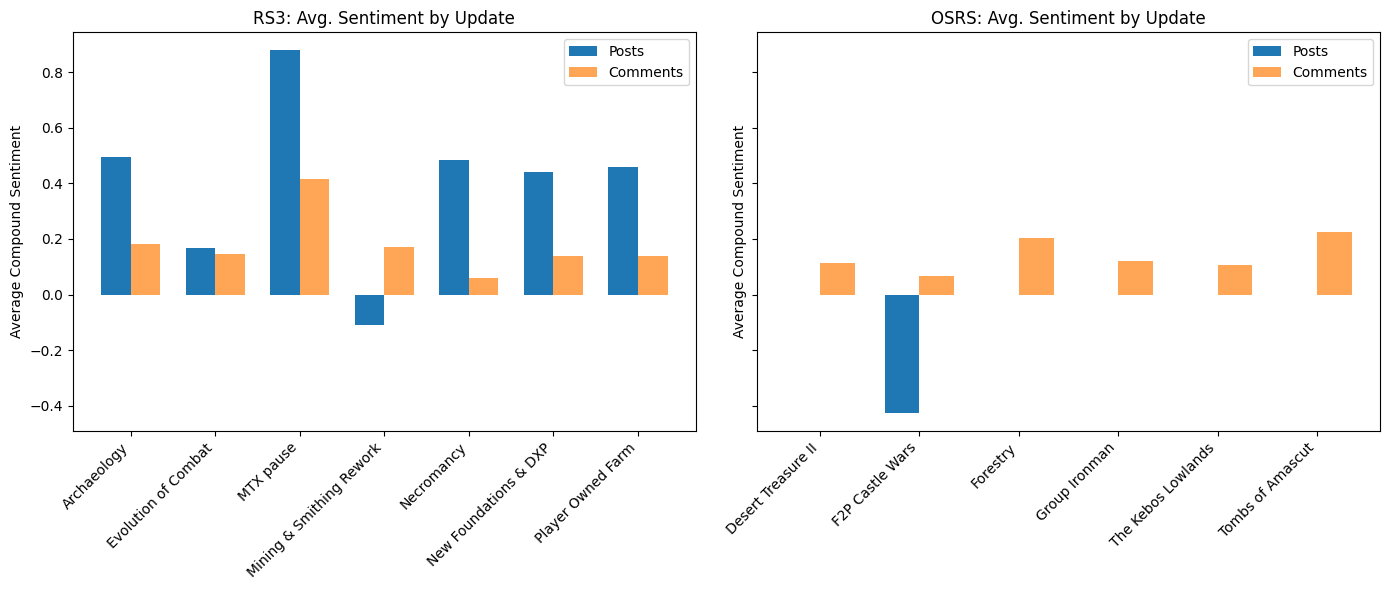

In [55]:
# If we want to visualize it with a grouped bar chart
# prepare a thin bar offset
width = 0.35

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, game in zip(axes, ['RS3','OSRS']):
    # filter just this game
    df = sentiment_summary[sentiment_summary['game']==game]
    updates = df['update'].tolist()
    x = list(range(len(updates)))

    # plot posts and comments next to each other
    ax.bar([i - width/2 for i in x],
           df['avg_post_sentiment'],
           width, label='Posts')
    ax.bar([i + width/2 for i in x],
           df['avg_comment_sentiment'],
           width, label='Comments', alpha=0.7)

    # labels & styling
    ax.set_xticks(x)
    ax.set_xticklabels(updates, rotation=45, ha='right')
    ax.set_title(f'{game}: Avg. Sentiment by Update')
    ax.set_ylabel('Average Compound Sentiment')
    ax.legend()

plt.tight_layout()
plt.show()

Across both games we see clear differences in how announcement posts and  discussions are tonally skewed. There's also a striking contrasts between RS3 and OSRS communities.

### RS3: Enthusiasm for new content

In the RS3 forums we find high enthusiasm for new content and some pushback on reworks.

- Not surprisingly the idea of pausing MTX (microtransactions) stands out by a mile. The official post is nearly off the charts positive (0.88), and even the comments show a strong positive skew (0.41). This comes naturally as the community may feel relief or excitement over the idea of reducing the "buy your way up" and the experiments will help with trying different ways of revenue while increasing player engagement.

- New skills such as Archaeology, or Necromancy and quality of life updates, such as "New Foundations & DXP", or the "Player Owned Farm" update. They all generate highly positive posts (0.44 to 0.50). Comments, however, are more muted, clustering between 0.06 to 0.18, suggesting a more moderate but lightly positive discussion.

- Evolution of Combat (2012 overhaul) is only modestly positive in posts (0.17) and comments (0.15), reflecting its controversial legacy.

- The "Mining and Smithing Rework" is the only update with negative post sentiment (–0.11), yet comments rebound to positive (0.17), perhaps there's early shock in the OP announcement, but followed by constructive debate.

### OSRS: Neutral announcements

Almost every official OSRS thread post has neutral sentiment (0.00). They are typically posts with a link to the news website or simple polls with minimal narrative text.

- F2P Castle Wars is the one outlier, with a negative announcement (-0.43), likely driven by community joking or "F2P limitations" language in the title/body.

- Comments for every update are consistently positive (0.07 to 0.23), with the strongest enthusiasm around major content releases like Tombs of Amascut (0.23) and Forestry (0.20).


### Tone comparison

RS3 posts average across updates: 0.47
OSRS posts average: -0.07  (driven down by the one very negative F2P post)


RS3 comments average around 0.15; OSRS comments average around 0.15 as well.

RS3's official announcements use more positive language overall, while OSRS announcements stay neutral (aside from the one F2P thread). But community sentiment in both forums converges around +0.15 once discussion begins in the ccomments, regardless of game. This suggests that player discussions settle into a broadly positive tone no matter how the post is worded.

## Sentiment by Aspects

In [33]:
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [30]:
# initialize VADER
sia = SentimentIntensityAnalyzer()

# define aspects
aspects = ["combat", "quest", "monetization", "dxp", "mtx", "skill", "update", "boss"]

def aspect_sentiment(df, aspects):
    """
    For each aspect, find all sentences mentioning it in df['body'],
    compute their VADER compound scores, and average.
    """
    records = []
    for aspect in aspects:
        scores = []
        # iterate over all texts once
        for text in df['body'].dropna():
            for sent in sent_tokenize(text):
                if re.search(rf"\b{aspect}\b", sent, re.IGNORECASE):
                    scores.append(sia.polarity_scores(sent)['compound'])
        records.append({
            "aspect": aspect,
            "mentions": len(scores),
            "avg_sentiment": np.mean(scores) if scores else np.nan
        })
    return pd.DataFrame(records)

In [34]:
# Run it for each game and comments, we can also do posts
rs3_aspect = aspect_sentiment(df_rs3_comments, aspects)
rs3_aspect['game'] = 'RS3'

osrs_aspect = aspect_sentiment(df_osrs_comments, aspects)
osrs_aspect['game'] = 'OSRS'

In [35]:
# we now combine and view
aspect_summary = pd.concat([rs3_aspect, osrs_aspect], ignore_index=True)
print(aspect_summary)

          aspect  mentions  avg_sentiment  game
0         combat       368      -0.141890   RS3
1          quest        81       0.104685   RS3
2   monetization        32       0.220956   RS3
3            dxp       152       0.147719   RS3
4            mtx       885       0.203605   RS3
5          skill       645       0.113976   RS3
6         update       171       0.196817   RS3
7           boss       200      -0.096061   RS3
8         combat       138      -0.164454  OSRS
9          quest       410       0.178730  OSRS
10  monetization         0            NaN  OSRS
11           dxp         0            NaN  OSRS
12           mtx        32      -0.051584  OSRS
13         skill       325       0.140477  OSRS
14        update       276       0.160209  OSRS
15          boss       248      -0.019251  OSRS


/tmp/ipython-input-36-3718331345.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(aspects, rotation=45, ha='right')


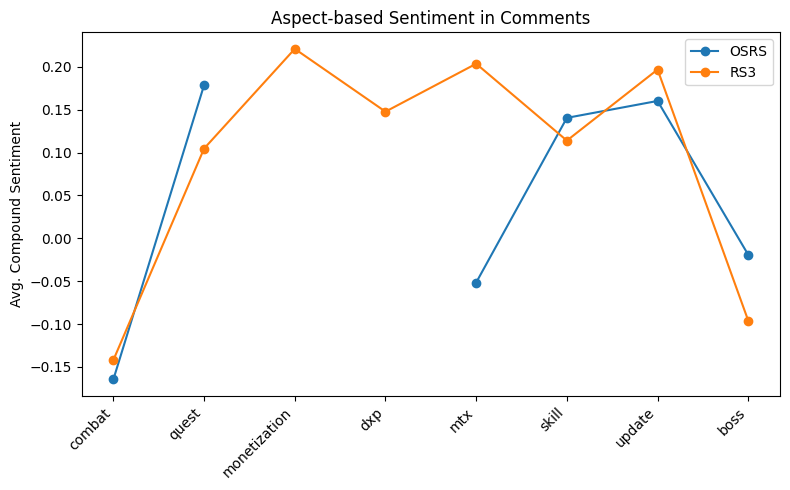

In [36]:
# visualizing aspects
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))

for game, group in aspect_summary.groupby('game'):
    ax.plot(group['aspect'], group['avg_sentiment'], marker='o', label=game)

ax.set_xticklabels(aspects, rotation=45, ha='right')
ax.set_ylabel("Avg. Compound Sentiment")
ax.set_title("Aspect‑based Sentiment in Comments")
ax.legend()
plt.tight_layout()
plt.show()

Some negative aspects include combat, which clearly seems a sore point in both communities, with average comment sentiment of -0.14 (RS3) and -0.16 (OSRS). Players are voicing more frustration than praise when "combat" comes up. Wihch is unsurprising given the eternal debates over balance and mechanics.

Bossing also skews negative (-0.10 RS3, -0.02 OSRS), but less so in OSRS. This suggests that while both groups may complain about boss encounters (drop rates, difficulty spikes), the OSRS fan-base may be slightly more forgiving or have fewer complaints.

Some positive aspects include monetization (“monetization” or shorthand “mtx”) shows up with very high positivity in RS3 (Monetization) +0.22, though only 32 mention; and (MTX) +0.20, with 885 mentions.

This contrasts with OSRS's near neutral or slightly negative MTX score (-0.05 on 32 mentions), reflecting the very different view points: RS3 discussions praising Jagex's efforts in trying new features, and OSRS players mostly hostile to microtransactions.

Quest lines seem fairly positive accros both games with +0.10 (RS3) and +0.18 (OSRS). OSRS players especially like to talk about their quest content, including Kebos and Desert Treasure expansions.

Another overall positive aspect for both includes skill lines, with +0.11 (RS3) and +0.14 (OSRS). Both communities welcome new skills (Archaeology, Necromancy, Forestry), but OSRS slightly higher than RS3 suggests a bit more excitement about skill launches there.

Mentions of the word "update" are strongly positive in both games, with +0.20 (RS3) and +0.16 (OSRS). This aligns with the overall finding that community sentiment around patch releases is typically upbeat, regardless of the specific content.

DXP appears only in RS3 comments (152 sentences), with a healthy +0.15 average, Indicating players love bonus XP events.

OSRS comments had no DXP mentions since it doesn't feature those events.

## Conclusions

This analysis explored two RuneScape communities that exhibit different network structures. In RS3, user discussions can be grouped into seven large but tightly interwoven clusters (density of around 0.19, transitivity of around 0.89), meaning that conversations around different updates overlap heavily and flow freely between topics. In contrast, OSRS groups into eleven smaller communities more focused in specific updates (density of around 0.14, transitivity of around 0.79) that rely on a handful of super connectors to bridge what would otherwise be isolated groups. This suggests that RS3 players tend to discuss in a wider variety of threads across content releases, while OSRS fans congregate more around each individual update.

Findings around sentiment, we see that RS3's official announcements carry a strongly positive tone (average compound around +0.47), especially for features like the MTX pause and new skills, and the ensuing comments remain moderately upbeat (around +0.15). OSRS announcements, by contrast, are almost entirely neutral in wording (average of 0.07) but still have positive discussion once updates go live (around +0.15 comments). At the update level, both communities reward new content, such as the launch of Archaeology, Necromancy, Tombs of Amascut, and Forestry, and all find clearly positive comment sentiment. At the same time, controversial changes (such as the mining and smithing rework in RS3, or F2P Castle Wars in OSRS) generate negative or muted reactions before discussion rebounds.

Finally, regarding specific game facets, we see that "combat" and "boss" mechanics carry the most frustration (compound of around -0.15), while  "quests", "skills", and "updates" consistently make people excited. Monetization experiments (MTX, DXP) are positively received in RS3, given the overall negative perception of the feaures, while viewed negatively or ignored in OSRS, since monetization features are more reduced there. Taking everything into account, these findings may suggest that developers and mods can lean into the positive response to new content, and proactively address the pain points around combat and boss design. They could tailor their outreach, either by engaging super connecters users in RS3 or by reaching into each isolated update cluster in OSRS to maximize positive engagement across both fan bases.


